# Fourier Shell Correlation with a single image stack

Ideally for FRC/FSC analysis one would have two independent observations of the region-of-interest. With 3D stacks, if only using a single detector, such a requirement is not very practical -- as acquiring two stacks will double the acquisition time and increase photobleaching. Also there's a plethora of existing image datasets on most researchers hard drives that might be of interest to analayse. 

For these reason I wanted to see if it would be possible to get a reasonable resolution estimate from a single stack only, by splitting it into two sub-stacks. 

In [1]:
%matplotlib inline
from ipywidgets import interact, fixed

import os
import supertomo.ui.frc_options as options
from supertomo.ui.plots.image import display_2d_images
from supertomo.data.io import read
import supertomo.processing.image as imops
from supertomo.analysis.resolution.fourier_shell_correlation import DirectionalFSC
import supertomo.data.iterators.fourier_shell_iterators as iterators
import supertomo.analysis.resolution.analysis as fsc_analysis
import supertomo.processing.windowing as windowing
from supertomo.data.containers.image import Image




def show_axial_slice(image1, image2, slice):
    display_2d_images(image1[slice], image2[slice])

## Data

A single 3D stack of a pollen sample was acquired with a Nikon A1 confocal microscope. First the dataset was resampled to isotropic spacing and zero padded to a cube -- after which it was split in two by using a checkerboard pattern. 

In [2]:
# Image
data_dir = os.path.join(os.getcwd(), "data")
image_name = "40x_TAGoff_z_galvo.nd2"

# Get script options
args_list = [data_dir, '--bin-delta=10', '--frc-curve-fit-degree=4', 
            '--resolution-threshold-criterion=half-bit', '--resolution-threshold-value=0.5',
            '--angle-delta=15', '--enable-hollow-iterator', '--extract-angle-delta=.1', 
             '--resolution-point-sigma=0.01', '--use-splines']
args = options.get_frc_script_options(args_list)

# Get image
image = read.get_image(os.path.join(data_dir, image_name), channel=0)

# Pre-process
image = imops.zoom_to_isotropic_spacing(image, order=0)
image = imops.zero_pad_to_cube(image)
image = imops.crop_to_shape(image, [500]*3)

image1, image2 = imops.checkerboard_split(image)

image1 = Image(windowing.apply_hamming_window(image1), image1.spacing)
image2 = Image(windowing.apply_hamming_window(image2), image2.spacing)

interact(show_axial_slice, image1=fixed(image1), image2=fixed(image2), slice=(0, image1.shape[0]-1))

The zoom is [3.2154696132596685, 1.0, 1.0]


/Users/sami/anaconda/envs/supertomo2/lib/python2.7/site-packages/traitlets/traitlets.py:567: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  silent = bool(old_value == new_value)


interactive(children=(IntSlider(value=124, description=u'slice', max=249), Output()), _dom_classes=('widget-interact',))

<function __main__.show_axial_slice>

In [3]:
iterator = iterators.HollowConicalFourierShellIterator(image1.shape, args.d_bin, args.d_angle, args.d_extract_angle)
fsc_task = DirectionalFSC(image1, image2, iterator)

data = fsc_task.execute()
analyzer = fsc_analysis.FourierCorrelationAnalysis(data, image1.spacing[0], args)
result = analyzer.execute()

Optimization terminated successfully.
         Current function value: 0.000052
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000070
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000025
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000031
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000072
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000022
         Iterations: 12
         Function evaluations: 24
Optimization terminated successfully.
         Current function value: 0.000157
         Iterations: 13
         Function evaluations: 26
Optimization terminated successful

/Users/sami/Programming/GIT/supertomo2/supertomo/processing/ndarray.py:190: RuntimeWarning: invalid value encountered in divide
  result = numerator / denominator


## Results

The results look correct, but I am not sure about the numerical values, as I don't know the NA exactly.

$r_{xy} =  \frac{ 0.6 \lambda}{{NA}}$

$r_{z} = \frac{1.4 \lambda \eta}{{NA}^2} $

I'm going to confirm manually by line profile measurements.

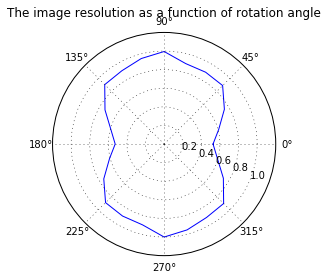

In [4]:
import supertomo.ui.plots.frc as frcplots

plotter = frcplots.FourierDataPlotter(result)
plotter.plot_polar()

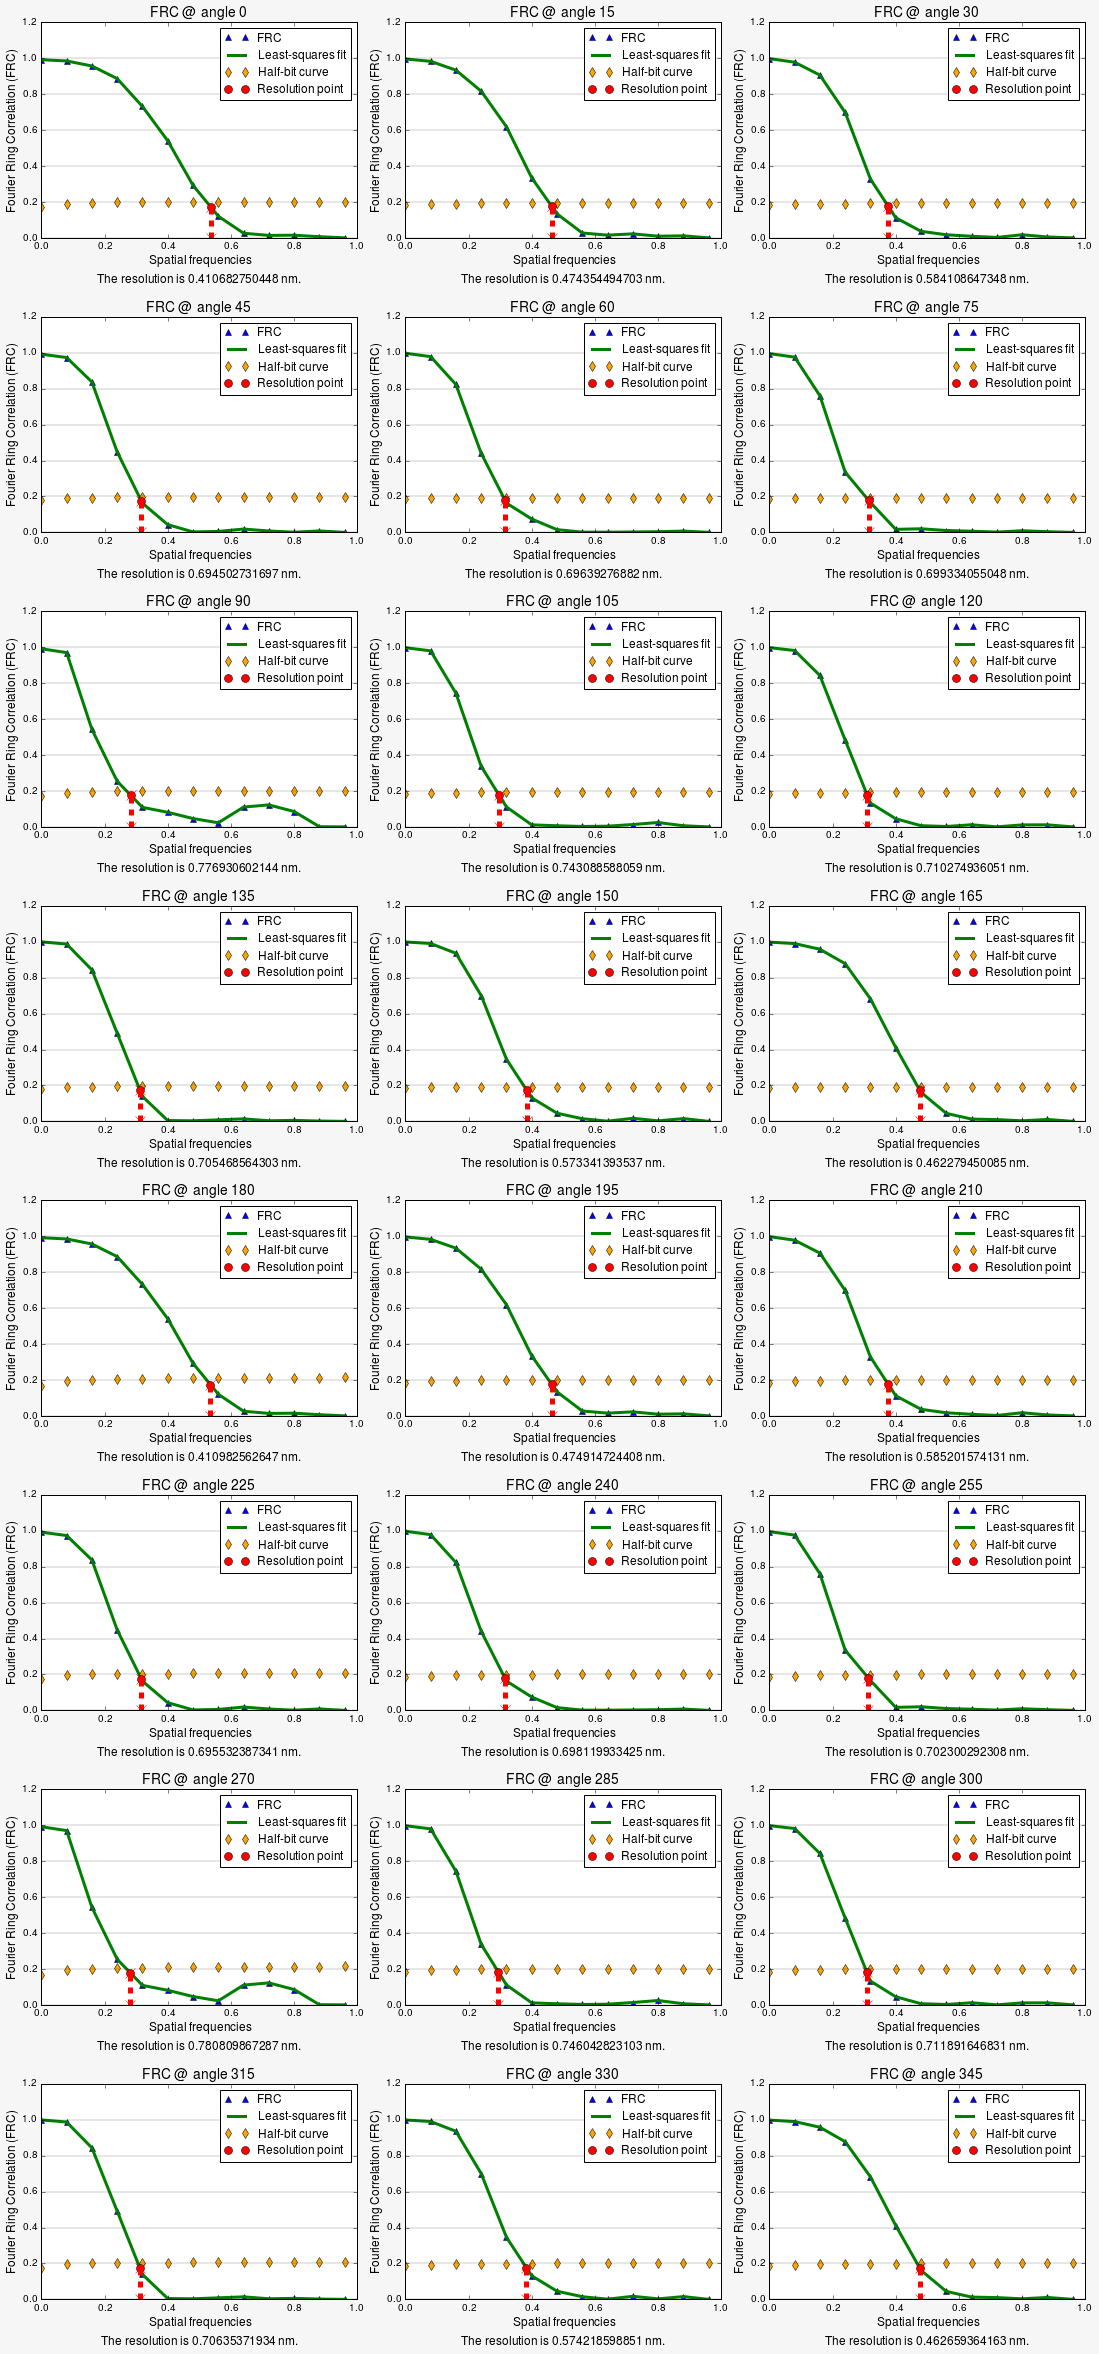

In [5]:
plotter.plot_all()